In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 32 #batch size
virsion = 95 #version number

In [2]:
!nvidia-smi

Sat Mar 15 07:13:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import timm
from fastai import *
from fastai.vision.all import *
import torch.nn as nn
import torch

In [3]:
!pip install timm

In [23]:
!pip install google-colab

In [4]:
#download dataset directy from kaggle
!pip install kaggle

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/raf-db-dataset


In [6]:
%cd /kaggle/input

/kaggle/input


In [32]:
!unzip -n raf-db-dataset.zip

unzip:  cannot find or open raf-db-dataset.zip, raf-db-dataset.zip.zip or raf-db-dataset.zip.ZIP.


In [11]:
#cheking the number of classes
import os
dataset_path = "/kaggle/input/raf-db-dataset"
num_images = len(os.listdir(dataset_path))
print(num_images)

3


In [12]:
# Define Class Mapping for RAF-DB Dataset
class_mapping = {
    "1": "Surprise",
    "2": "Fear",
    "3": "Disgust",
    "4": "Happiness",
    "5": "Sadness",
    "6": "Anger",
    "7": "contempt"
}

In [13]:
# Function to Map Folder Names to Labels
def get_raf_label(file_path):
    return class_mapping[str(file_path.parent.name)]

# Define DataBlock for RAF-DB with Stronger Augmentation and Regularization
bs = 32  # Batch size (adjust based on available memory)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    get_y=get_raf_label,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(size=224, do_flip=True, flip_vert=False, max_rotate=30.0,
                        max_zoom=1.3, max_lighting=0.5, max_warp=0.4,
                        p_affine=0.9, p_lighting=0.9),
        Normalize.from_stats(*imagenet_stats)
        #CutMix(alpha=1.0),  # Creates mixed images to improve generalization (Commented out to prevent error)
        #MixUp(alpha=0.4)  # Smoothly blends images for regularization (Commented out to prevent error)
    ]
)

In [14]:
# Create the dataloaders object using the DataBlock
dls = dblock.dataloaders(dataset_path, bs=bs)  # Assuming dataset_path and bs are defined


In [15]:
len(dls.train.dataset), len(dls.valid.dataset)

(12271, 3068)

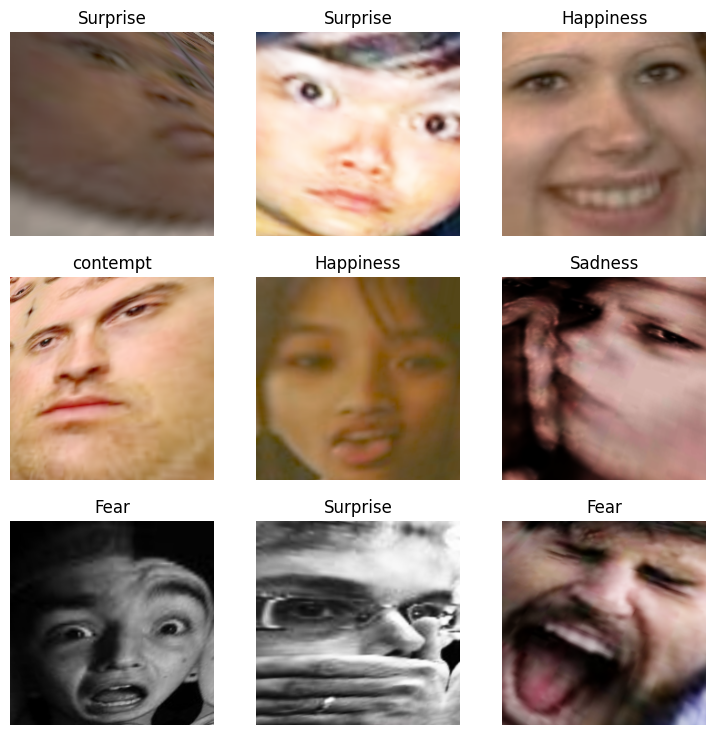

In [16]:
dls.train.show_batch()

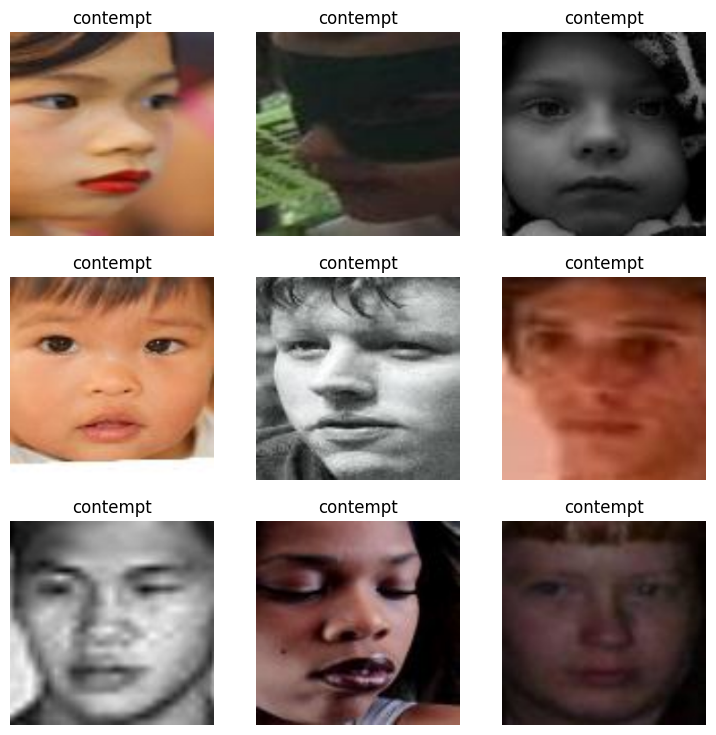

In [17]:
dls.valid.show_batch()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score

In [19]:
# 1. Load Pre-trained EfficientNetV2 Model
model = timm.create_model('resnet50', pretrained=True)  

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [20]:
# 2. Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

In [21]:
# 3. Get the number of input features for the final fully connected layer
num_ftrs = model.fc.in_features  # This is the number of input features to the final fully connected layer

# 4. Modify the final layer for emotion classification (fine-tune the last layer)
num_classes = 7  # Number of emotion classes (adjust as needed)

In [22]:
# Modify the final fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Dropout for regularization
    nn.Linear(num_ftrs, 512),
    nn.LeakyReLU(0.1),  # LeakyReLU activation
    nn.Dropout(0.5),  # Another dropout layer
    nn.Linear(512, num_classes)  # Output layer for emotion classification
)


In [23]:
# 4. Unfreeze the last few blocks and the fully connected layer for fine-tuning
for param in model.layer4.parameters():  # Unfreeze the last block layers
    param.requires_grad = True

for param in model.fc.parameters():  # Ensure the classifier layer is trainable
    param.requires_grad = True

In [24]:
# 5. Set model to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
# 6. Advanced Data Augmentation (Added more transformations)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flip for data augmentation
    transforms.RandomRotation(20),  # Random rotation to help the model generalize
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformations (shift)
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Random perspective distortion
    transforms.Resize((224, 224)),  # Resize to the size that ResNet-50 expects (224x224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [26]:
#7Replace 'DATASET/train' and 'DATASET/test' with the actual paths to your data
train_dataset = datasets.ImageFolder(root='/kaggle/input/raf-db-dataset/DATASET/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root='/kaggle/input/raf-db-dataset/DATASET/test', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
# 8. Define the optimizer and loss function
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # Adjust based on your dataset class distribution
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))  # Cross-entropy loss with class weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer with a learning rate of 0.0001

In [28]:
# 9. Learning rate scheduler (StepLR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR by half every 10 epochs


In [29]:
# 10. Early stopping variables
best_val_accuracy = 0
patience = 5  # Number of epochs to wait for improvement
no_improvement = 0

In [31]:

# 11. Training loop
epochs = 100  # Increase epochs for better performance

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds * 100
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 12. Validation loop (Optional, to check performance on validation data)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds * 100
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

import os

# Create directory if it doesn't exist
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Now save your model to this directory
if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    no_improvement = 0
    # Save model to the specified directory
    torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
else:
    no_improvement += 1

if no_improvement >= patience:
    print(f'Early stopping at epoch {epoch+1}')
    break

# Save the model every 20% of epochs
if epoch + 1 in checkpoint_intervals:
    torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))
    print(f"Model saved at epoch {epoch + 1}.")

# 13. Test the model (on unseen data)
model.eval()  # Set the model to evaluation mode for inference
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Use the validation dataset as a test set

all_preds = []
all_labels = []

with torch.no_grad():  # No need to track gradients during inference
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluate accuracy on test set
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100, Loss: 1.6301, Accuracy: 38.74%
Validation Loss: 1.5647, Validation Accuracy: 38.69%
Epoch 2/100, Loss: 1.5320, Accuracy: 41.33%
Validation Loss: 1.4510, Validation Accuracy: 45.60%
Epoch 3/100, Loss: 1.4291, Accuracy: 46.54%
Validation Loss: 1.3487, Validation Accuracy: 50.13%
Epoch 4/100, Loss: 1.3543, Accuracy: 49.91%
Validation Loss: 1.2875, Validation Accuracy: 53.06%
Epoch 5/100, Loss: 1.3023, Accuracy: 52.29%
Validation Loss: 1.2411, Validation Accuracy: 55.35%
Epoch 6/100, Loss: 1.2702, Accuracy: 53.68%
Validation Loss: 1.2268, Validation Accuracy: 54.95%
Epoch 7/100, Loss: 1.2362, Accuracy: 55.14%
Validation Loss: 1.1769, Validation Accuracy: 57.01%
Epoch 8/100, Loss: 1.1976, Accuracy: 56.15%
Validation Loss: 1.1460, Validation Accuracy: 58.28%
Epoch 9/100, Loss: 1.1841, Accuracy: 57.05%
Validation Loss: 1.1148, Validation Accuracy: 60.07%
Epoch 10/100, Loss: 1.1637, Accuracy: 57.93%
Validation Loss: 1.0916, Validation Accuracy: 60.04%
Epoch 11/100, Loss: 1.1378, A

OSError: [Errno 30] Read-only file system: './saved_models'

In [33]:
torch.save(model.state_dict(), '/kaggle/working/custom_resnet50_emotion_model.pth')


# To load the model later:


In [34]:
# Function to inspect gradients after each backward pass
def inspect_gradients(model):
    for name, param in model.named_parameters(): # Access model parameters directly
        if param.grad is not None:
            print(f"{name}: {param.grad.abs().mean()}")

# Assuming 'model' is your trained model
inspect_gradients(model)

layer4.0.conv1.weight: 0.0006230854778550565
layer4.0.bn1.weight: 0.0075675807893276215
layer4.0.bn1.bias: 0.004211459308862686
layer4.0.conv2.weight: 0.00021992158144712448
layer4.0.bn2.weight: 0.0030656440649181604
layer4.0.bn2.bias: 0.001953806495293975
layer4.0.conv3.weight: 0.00036994757829234004
layer4.0.bn3.weight: 0.0033803461119532585
layer4.0.bn3.bias: 0.0018034344539046288
layer4.0.downsample.0.weight: 0.0002297222672495991
layer4.0.downsample.1.weight: 0.002966725267469883
layer4.0.downsample.1.bias: 0.0018034344539046288
layer4.1.conv1.weight: 0.0003711822209879756
layer4.1.bn1.weight: 0.003729209303855896
layer4.1.bn1.bias: 0.0025585400871932507
layer4.1.conv2.weight: 0.00022650952450931072
layer4.1.bn2.weight: 0.005062065087258816
layer4.1.bn2.bias: 0.0029419714119285345
layer4.1.conv3.weight: 0.0003127535164821893
layer4.1.bn3.weight: 0.0035975100472569466
layer4.1.bn3.bias: 0.001861603930592537
layer4.2.conv1.weight: 0.00030599714955314994
layer4.2.bn1.weight: 0.004338